# Hormonal contraceptives effect on HPV infection 
## Final project in Practical Bayes 2025

**Synopsis:**
Human papillomavirus (HPV) is a common group of viruses. There are many HPV genotypes, but particular genotypes called "high-risk HPV" have been shown to cause cervical cancer.

HPV is transmitted sexually through skin-to-skin contact. The virus clears itself out in most cases thanks to the immune system. However, persistent infection with high-risk HPV genotypes can cause changes in cells (precancerous conditions) and, if untreated, may lead to cervical cancer. HPV causes also other types of cancers like penile, anal or throat cancer.

The national vaccination program against high-risk HPV started in 2018, and 12-14-year-old boys and girls are now routinely vaccinated in Estonia. However, the HPV vaccine is effective before the initiation of sexual activity and protects only against specific HPV genotypes. Therefore, HPV screening continues to be important in all age groups, but especially in unvaccinated cohorts.

In Estonia, women aged 30-65 are invited to cervical cancer screening programs. It is also known that many people don't attend screening because of different barriers. Therefore, to get a clearer picture of the high risk HPV prevalence and risk factors, we collected population-based data.

This dataset consists of cross-sectional data of 1000 Estonian women aged 30-70 years. Women were invited to a study via mail or e-mail. They filled in a questionnaire (paper or online) and also gave a self-sampling HPV test that was sent to a lab for analysis and genotyping.

Our research question currently is: **Do hormonal contraceptives increase the risk of high-risk HPV infection?**

**Variables:**
* **age**  - age at the time of study (years)
* **first_sex** - age at first intercourse (years)
* **nr_of_sex_partners** - nr of lifetime sexual partners
* **smoking** - current smoking status (1=smoker/0=non-smoker)
* **hormonal_contrcptvs** - ever used hormonal contraception (including birth control pills, hormonal iud, vaginal ring, hormonal implants, hormonal patches or shots) (1=yes/0=no)
* **hrhpv_prevalence** - test result for high-risk HPV (1=positive/0=negative)

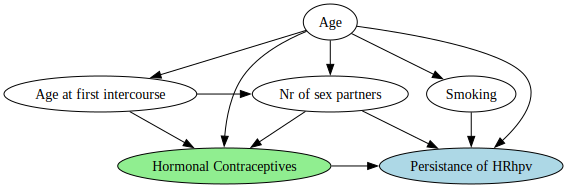

In [1]:
from graphviz import Digraph

dot = Digraph(comment='Persistance of HRhpv infection due to Hormonal Conterseptives ')
dot.node('A', 'Age')
dot.node('N', 'Nr of sex partners')
dot.node('F', 'Age at first intercourse')
dot.node('X', 'Hormonal Contraceptives', style='filled', fillcolor="lightgreen") 
dot.node('S', 'Smoking')
dot.node('Y', 'Persistance of HRhpv', style='filled', fillcolor="lightblue") 
dot.edges(['AN', 'AF', 'AY', 'AS', 'AX', 'FX', 'NX', 'NY', 'SY']) # add edges
dot.edge('F', 'N', constraint='false') # add an edge with constraint
dot.edge('X', 'Y', constraint='false') # add an edge with constraint

#print(dot.source) # print the dot file

dot

## Simulation of data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import seaborn as sns

Some distributions of generated data by age group
          nr_of_sex_partners                     
                        mean count median min max
age_group                                        
0.0                 7.087302   252    7.0   1  14
1.0                 5.468354   237    5.0   1  12
2.0                 3.670588   255    3.0   1   9
3.0                 2.109375   256    2.0   1   7
          hormonal_contrcptvs                     
                         mean count median min max
age_group                                         
0.0                  0.908730   252    1.0   0   1
1.0                  0.594937   237    1.0   0   1
2.0                  0.439216   255    0.0   0   1
3.0                  0.281250   256    0.0   0   1
            smoking             
               mean count median
age_group                       
0.0        0.146825   252    0.0
1.0        0.164557   237    0.0
2.0        0.141176   255    0.0
3.0        0.097656   256    0.0
          hr

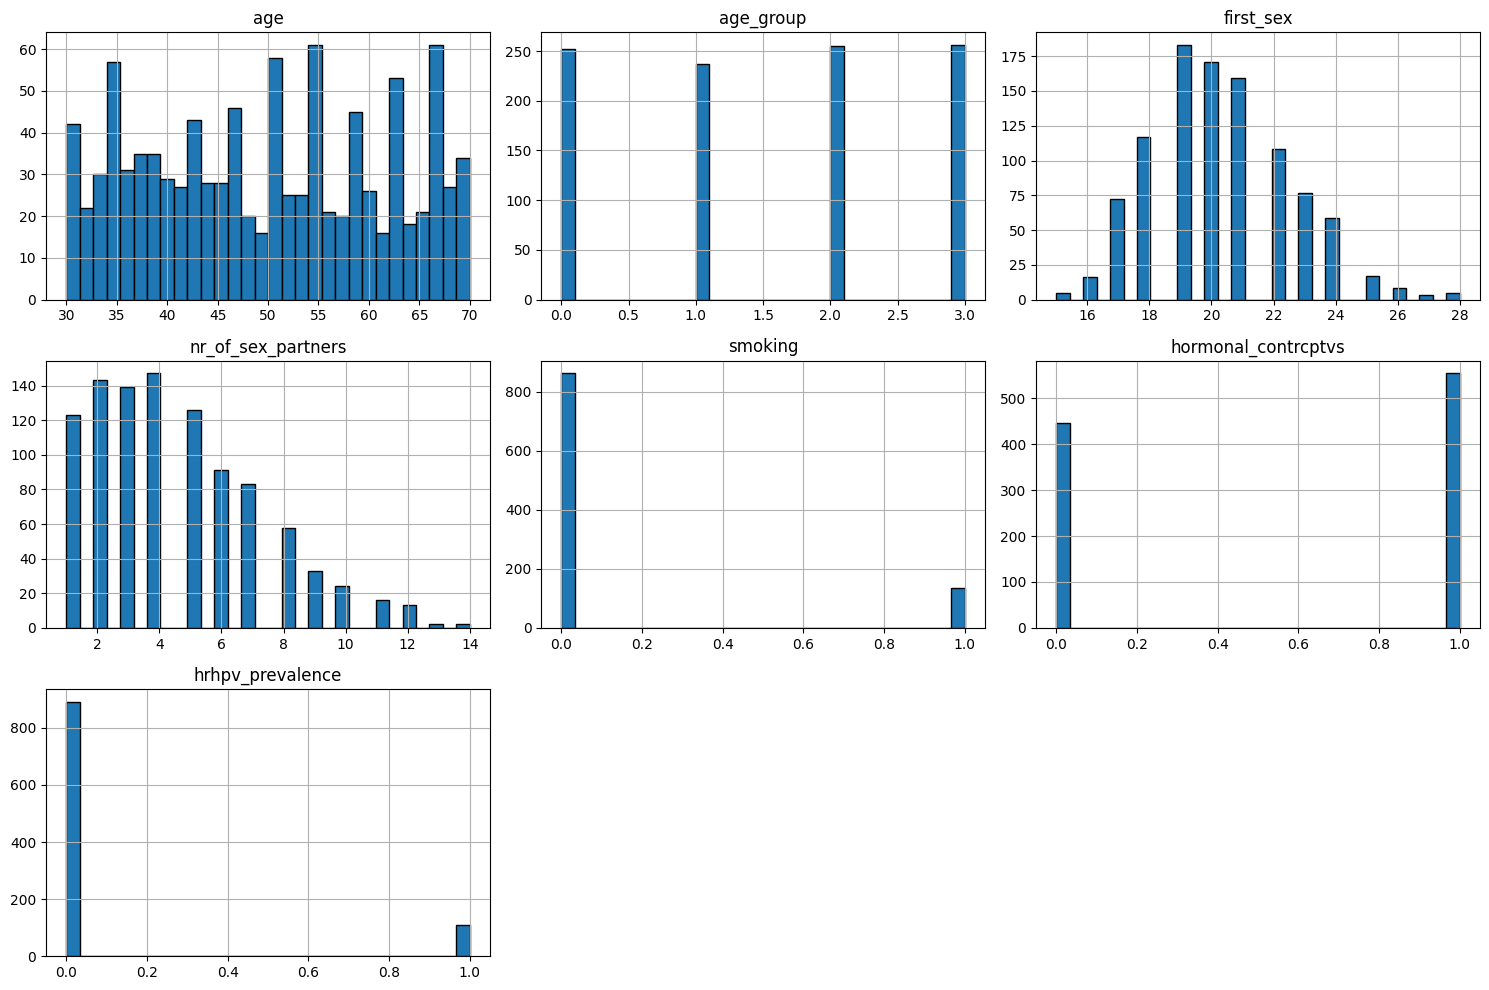

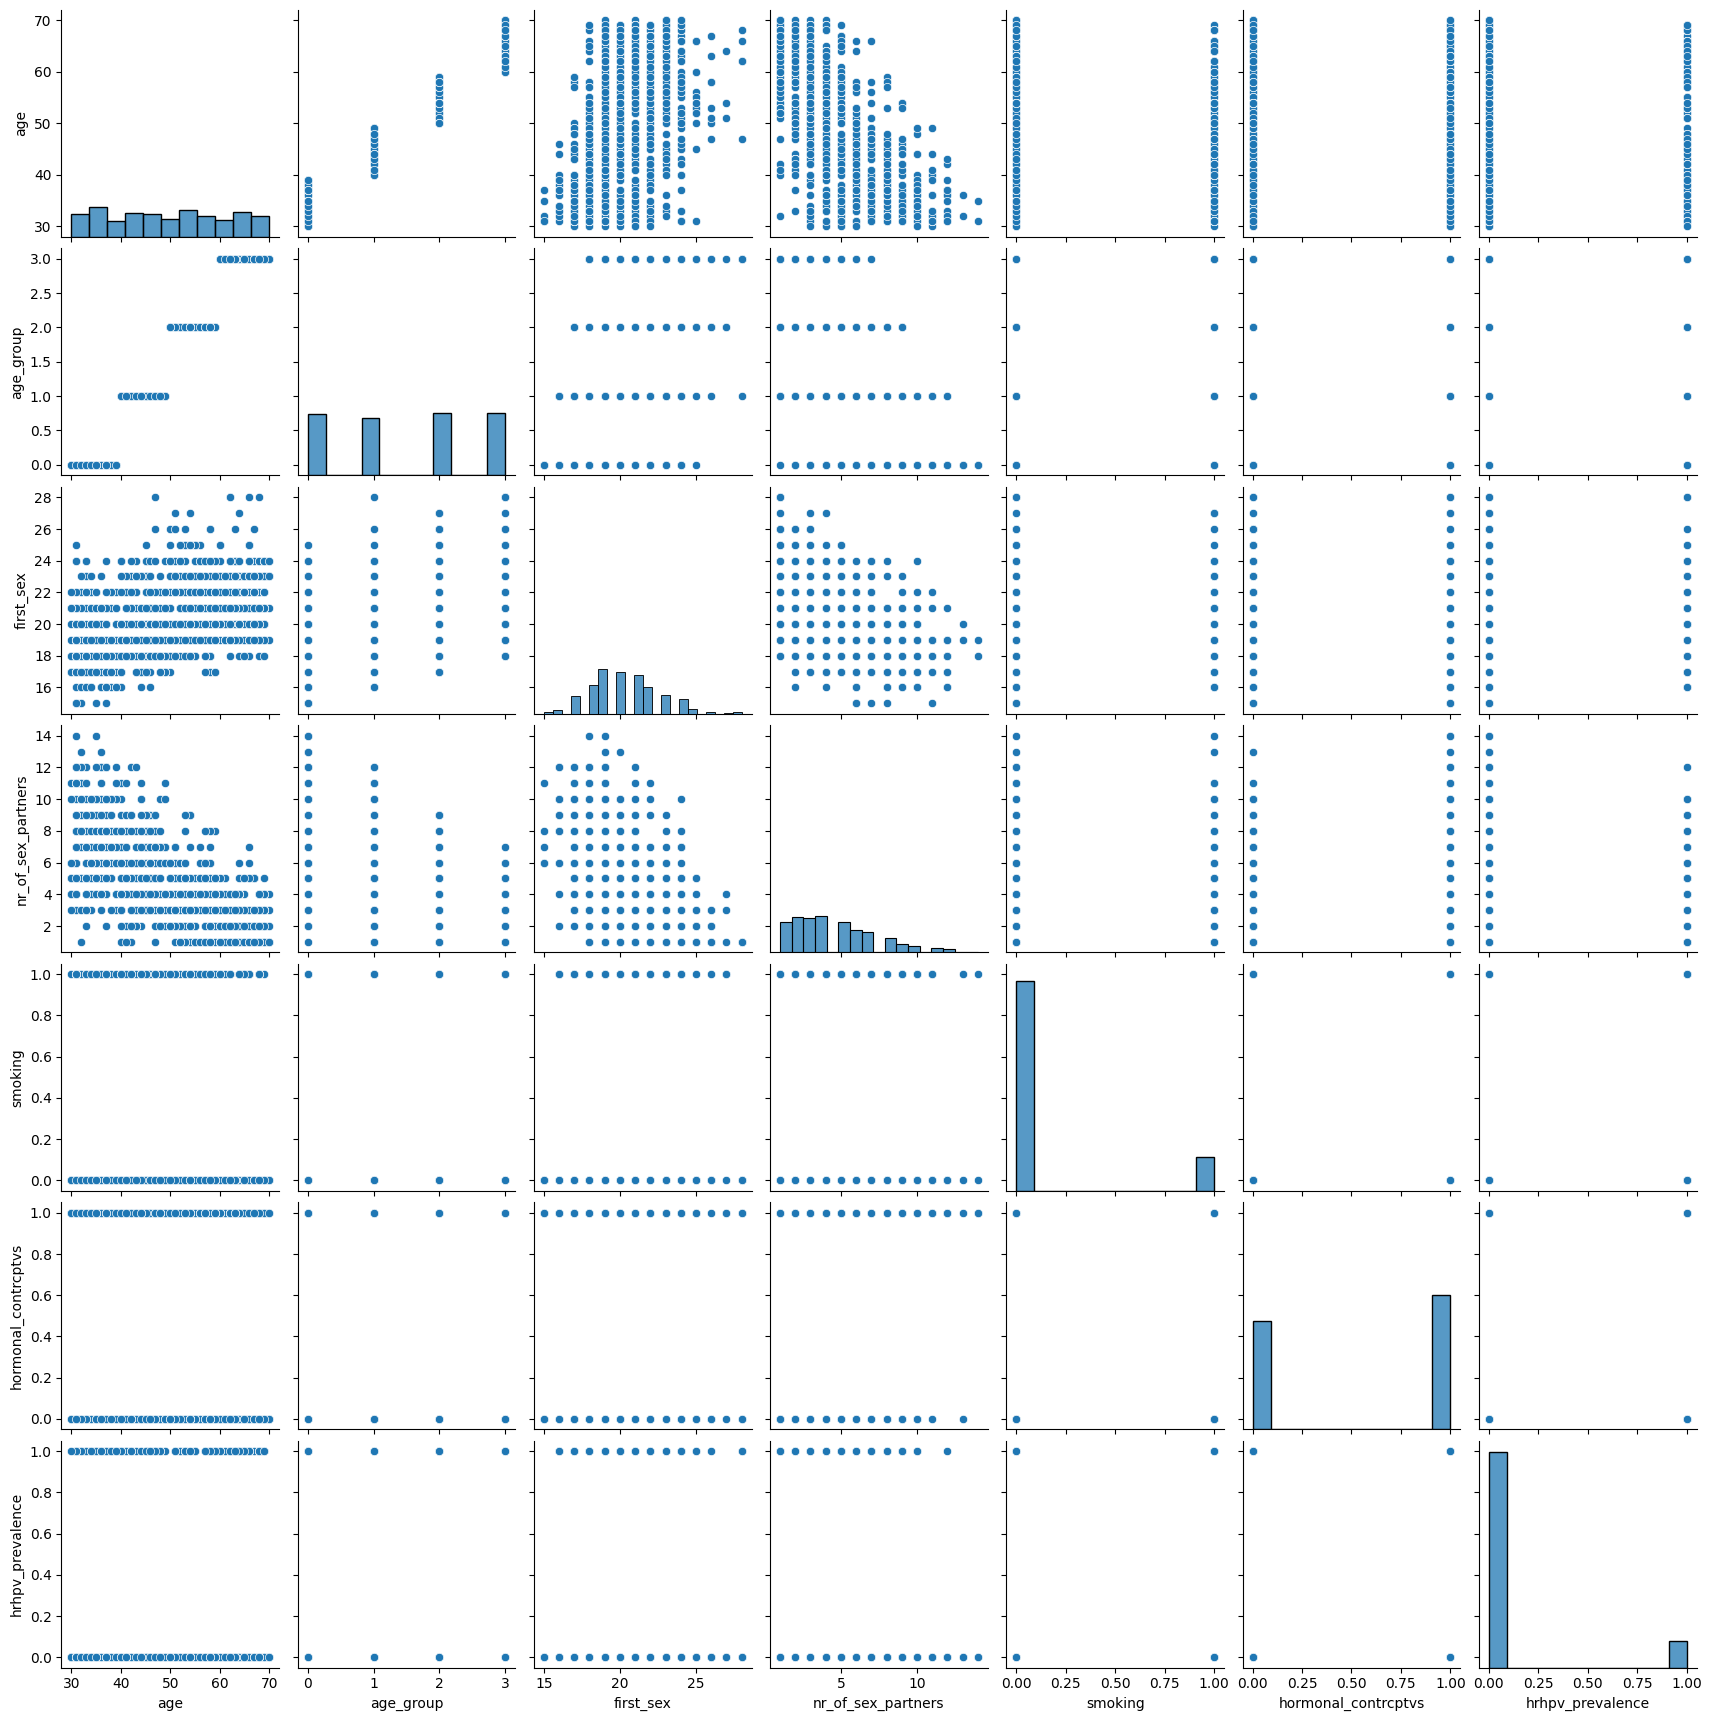

In [3]:
# Simulate height and weight from independent normal distributions
n_samples = 1000
np.random.seed(42)
df = pd.DataFrame()

# Start by generating age
df['age'] = np.random.uniform(low=30, high=70, size=n_samples).round(0) # age in full years
# Create 10 year age groups (30-39,40-49,50-59,60-70) coded (0,1,2,3) accordingly 
df['age_group'] = np.floor(df.age/10 - 30/10) # 10 year age groups
df['age_group'] = np.where(df.age_group < 3, df.age_group, 3) # joining 70 year-olds with 60-70 group

# Start of sexual life is later for older generation, earlier for younger generation
df['first_sex'] = 11 + df.age_group + np.random.lognormal(mean=2, sigma=0.25, size=n_samples).round(0)

# Just to check that start of sexul life is not higher than age
df['first_sex'] = np.where(df.first_sex > df.age, df.age, df.first_sex) 
#df['years_of_sexual_life'] = df.age - df.first_sex

# Nr of sexual partners - inversly correlated to age and start of sexual life as older generations are more conservative
## On average for every 10 year age cohort women have 1.5 less sexual partners compared to previous age cohort
## Women who started their sexual life eariler tend to have more partners over their life span
mu=(6 - 1.5 * (df.age_group-1) - .3 * (df.first_sex - min(df.first_sex))).clip(lower=0)
# Since the data is only about sexually active women, then there is definitely 1 and then randomly adding based on mu.
df['nr_of_sex_partners'] = 1 + np.random.poisson(lam=mu, size=n_samples)


# Smoking is 
df['smoking'] = (np.random.uniform(size=n_samples) > (1./(1.+np.exp(-1.5 - .2*(df.age_group==1) - .08*(df.age_group==2) - .9*(df.age_group==3)))))*1

# Generate binary variable for hormonal contraceptives and HPV prevalence
logit_p1=(1./(1.+np.exp(2.9 - 1.3*(df.age_group==1) - 1.7*(df.age_group==2) - 2.3*(df.age_group==3) - .08 * df.first_sex + .1 * df.nr_of_sex_partners)))
df['hormonal_contrcptvs'] = (np.random.uniform(size=n_samples) > logit_p1)*1

# Generate binary variable for HPV prevalence
logit_p2=(1./(1.+np.exp(-2.5 + .6*df.hormonal_contrcptvs - .4*(df.age_group==1) - .35*(df.age_group==2) + .55*(df.age_group==3) + .2 * df.smoking + .03 * df.nr_of_sex_partners)))
df['hrhpv_prevalence'] = (np.random.uniform(size=n_samples) > logit_p2)*1

# Some check up within age groups
print("Some distributions of generated data by age group")
print(df.groupby(['age_group']).agg({'nr_of_sex_partners': ['mean', 'count', 'median', 'min', 'max']}))
print(df.groupby(['age_group']).agg({'hormonal_contrcptvs': ['mean', 'count', 'median', 'min', 'max']}))
print(df.groupby(['age_group']).agg({'smoking': ['mean', 'count', 'median']}))
print(df.groupby(['age_group']).agg({'hrhpv_prevalence': ['mean', 'count', 'median']}))

# Some check up within age groups
print("hrHPV prevalence in the data")
print(df.agg({'hrhpv_prevalence': ['mean', 'count', 'median']}))

# Detailed distributions by variable
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

# Pairwise distributions 
sns.pairplot(df)
plt.show()

In [4]:
# Remove age group
df = df.drop(columns=['age_group'])

In [5]:
# Example of the data 
df.head()

,age,first_sex,nr_of_sex_partners,smoking,hormonal_contrcptvs,hrhpv_prevalence
0,45.0,20.0,6,0,0,0
1,68.0,19.0,2,1,1,0
2,59.0,21.0,1,1,0,1
3,54.0,22.0,1,0,0,0
4,36.0,19.0,3,0,1,0


In [6]:
# Write data to csv
df.to_csv('hpv_prevalence.csv')

## Some more data reports

In [ ]:
# Run only if you want to generate a more thorough data report
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Full Data Overview")
profile.to_file("eda_report.html")


## Study different distributions

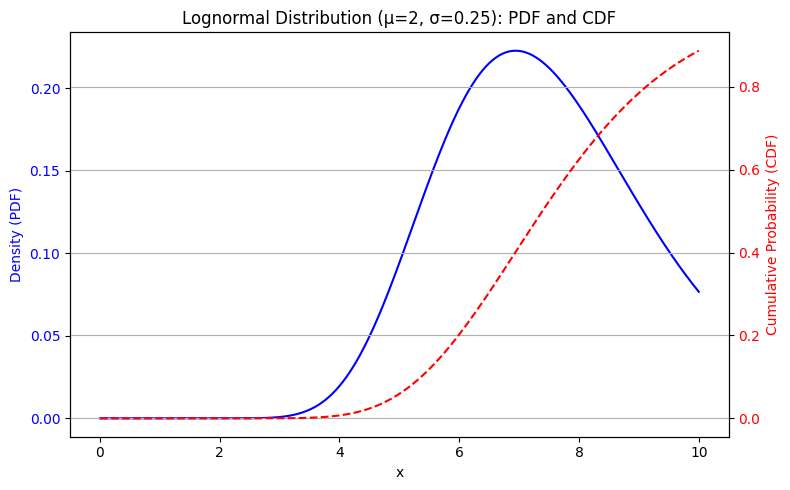

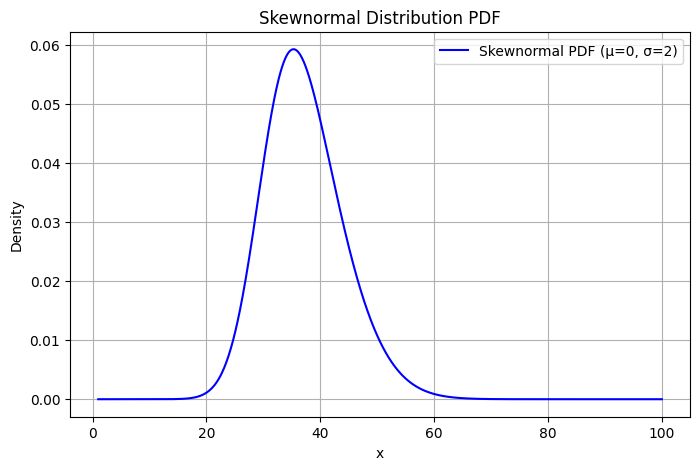

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import skewnorm

# x values
x = np.linspace(0.001, 10, 1000)

### -------- Lognormal --------
# Parameters
mu = 2
sigma = 0.25
s = sigma
scale = np.exp(mu)

# PDF and CDF
pdf = lognorm.pdf(x, s=s, scale=scale)
cdf = lognorm.cdf(x, s=s, scale=scale)

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# PDF on primary y-axis
ax1.plot(x, pdf, 'b-', label='PDF')
ax1.set_xlabel('x')
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# CDF on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(x, cdf, 'r--', label='CDF')
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and grid
plt.title(f'Lognormal Distribution (μ={mu}, σ={sigma}): PDF and CDF')
fig.tight_layout()
plt.grid(True)
plt.show()


### -------- Skewnormal --------
# Parameters
a = 2
mu = 30
sigma = 10

x = np.linspace(1, 100, 1000)

# Calculate the PDF
pdf = skewnorm.pdf(x, a=a, loc=mu, scale=sigma)

# Plot the PDF
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label='Skewnormal PDF (μ=0, σ=2)', color='blue')
plt.title('Skewnormal Distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()
